목표: 영화 리뷰 이진 분류  
과정:
- Preprocessing: 
    - MeCab을 사용해서 불용어를 처리하고 토큰화함 > 문장기호를 불용어로 추가함
    - FastText(subword) 방식으로 oov 문제를 해결하기 위해 적용해봄
- Data Pipeline:
    - train, validation: 비율을 8:2로 설정
    - batch size: 128로 설정
- trian, validation 함수 선언:
    - BCEWithLogitsLoss: 수치적 안정성을 위해 모델의 Sigmoid와 BCELoss를 BCEWithLogitsLoss로 통합함
    - 학습률 스케줄러: ReduceLROnPlateau(5회, 30%, mode='min')
    - 조기종료: val_loss 기준(15회)
- model 선언:
    - LSTM, CnnModel, FFN, SentimentModel, SentimentModel_emb
- model train:
    - model 선언
    - model train | validation
    - model test
    - model visualization
- optimizer 비교 (SentimentMode)

In [1]:
# !pip install konlpy
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab/
# !bash install_mecab-ko_on_colab_light_220429.sh

In [2]:
# # 실습에 활용할 수 있도록 라이브러리 설치 및 다운그레이드를 수행합니다
# !pip install gensim==4.3.2
# !conda install scipy==1.12.0 numpy==1.26.3 -y
# !mkdir -p sentiment_classification/data

In [3]:
# 현재 실행 환경에 맞게 변경
# !cd ~/work/sentiment_classification

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix

import re
import konlpy
from konlpy.tag import Mecab
import gensim
from gensim.models import FastText

import os
import copy
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(pd.__version__)
# print(konlpy.__version__)
# print(gensim.__version__)

---
### Preprocessing

In [5]:
# 데이터를 읽어봅시다.
data_dir = "./data/"
train_data = pd.read_table(data_dir+'ratings_train.txt')
test_data = pd.read_table(data_dir+'ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
vocab_size = 10000 # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256 # 워드 벡터의 차원수

In [8]:
# tokenizer = Mecab()
# stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '.', ',','<', '>', '(', ')']

# def load_data(train_data, test_data, num_words=10000):
#     train_data.drop_duplicates(subset=['document'], inplace=True)
#     train_data = train_data.dropna(how = 'any')
#     test_data.drop_duplicates(subset=['document'], inplace=True)
#     test_data = test_data.dropna(how = 'any')

#     X_train = []
#     for sentence in train_data['document']:
#         temp_X = tokenizer.morphs(sentence) # 토큰화
#         temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
#         X_train.append(temp_X)

#     X_test = []
#     for sentence in test_data['document']:
#         temp_X = tokenizer.morphs(sentence) # 토큰화
#         temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
#         X_test.append(temp_X)

#     words = np.concatenate(X_train).tolist()
#     counter = Counter(words)
#     counter = counter.most_common(num_words-4)
#     vocab = ["<PAD>", "<BOS>", "<UNK>", "<UNUSED>"] + [key for key, _ in counter]
#     word_to_index = {word:index for index, word in enumerate(vocab)}

#     def wordlist_to_indexlist(wordlist):
#         return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]


#     X_train = list(map(wordlist_to_indexlist, X_train))
#     X_test = list(map(wordlist_to_indexlist, X_test))

#     return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [9]:
# Mecab 및 불용어 설정
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '.', ',', '<', '>', '(', ')']

def load_data(train_data, test_data, num_words=10000):
    # 1. 데이터 중복 및 결측치 제거 (정확도: 높음)
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')

    # 2. 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if word not in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if word not in stopwords]
        X_test.append(temp_X)

    # 3. FastText를 이용한 어휘 사전 구축 (정확도: 높음)
    # sg=1(Skip-gram), min_count=5 등의 하이퍼파라미터 적용
    ft_model = FastText(sentences=X_train, vector_size=100, window=5, min_count=5, workers=4, sg=1)
    
    # FastText에서 학습된 단어들을 빈도순으로 가져옵니다.
    # num_words에서 예약 토큰 4개를 뺀 나머지만큼 가져옵니다.
    ft_vocab = ft_model.wv.index_to_key[:num_words-4]
    
    # 4. 예약 토큰 추가 및 word_to_index 생성
    vocab = ["<PAD>", "<BOS>", "<UNK>", "<UNUSED>"] + ft_vocab
    word_to_index = {word: index for index, word in enumerate(vocab)}

    # 5. 단어 리스트를 인덱스 리스트로 변환하는 함수 (정확도: 높음)
    def wordlist_to_indexlist(wordlist):
        # 문장 시작에 <BOS> 추가, 사전에 없는 단어는 <UNK> 처리
        return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    # 레이블 데이터 추출
    y_train = np.array(list(train_data['label']))
    y_test = np.array(list(test_data['label']))

    return X_train, y_train, X_test, y_test, word_to_index

In [10]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words=vocab_size)

In [11]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [12]:
index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '영화',
 5: '다',
 6: '고',
 7: '하',
 8: '을',
 9: '보',
 10: '..',
 11: '게',
 12: '!',
 13: '지',
 14: '있',
 15: '없',
 16: '?',
 17: '좋',
 18: '나',
 19: '었',
 20: '만',
 21: '는데',
 22: '너무',
 23: '봤',
 24: '적',
 25: '안',
 26: '로',
 27: '정말',
 28: '음',
 29: '것',
 30: '아',
 31: '네요',
 32: '어',
 33: '재밌',
 34: '같',
 35: '점',
 36: '지만',
 37: '진짜',
 38: '했',
 39: '기',
 40: '에서',
 41: '네',
 42: '않',
 43: '거',
 44: '았',
 45: '수',
 46: '되',
 47: '면',
 48: 'ㅋㅋ',
 49: '말',
 50: '인',
 51: '연기',
 52: '주',
 53: '내',
 54: '최고',
 55: '~',
 56: '평점',
 57: '이런',
 58: '던',
 59: '어요',
 60: '할',
 61: '왜',
 62: '겠',
 63: '해',
 64: '1',
 65: '스토리',
 66: '습니다',
 67: 'ㅋㅋㅋ',
 68: '...',
 69: '드라마',
 70: '아니',
 71: '생각',
 72: '더',
 73: '그',
 74: '싶',
 75: '사람',
 76: '듯',
 77: '때',
 78: '감동',
 79: '함',
 80: '배우',
 81: '본',
 82: '까지',
 83: '뭐',
 84: '보다',
 85: '알',
 86: '만들',
 87: '내용',
 88: '볼',
 89: '감독',
 90: '라',
 91: '그냥',
 92: '재미',
 93: '시간',
 94: '지루',
 

In [13]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[1, 30, 72, 937, 37, 227, 18, 31, 744]
라벨:  0
1번째 리뷰 문장 길이:  9
2번째 리뷰 문장 길이:  16


In [14]:
print(index_to_word[4])     # '.' 가 출력됩니다.
print(word_to_index['영화'])  # 4 이 출력됩니다.

영화
4


In [15]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

아 더 빙 진짜 짜증 나 네요 목소리
라벨:  0


In [16]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.711394038056916
문장길이 최대 :  116
문장길이 표준편차 :  11.940335384802193
pad_sequences maxlen :  39
전체 문장의 0.9341708516988415%가 maxlen 설정값 이내에 포함됩니다. 


In [17]:
def pad_sequences(data, maxlen):
    padded_data = []
    for sentence in data:
        if len(sentence) < maxlen:
            sentence = [0] * (maxlen - len(sentence)) + sentence
        else:
            sentence = sentence[:maxlen]
        padded_data.append(sentence)
    return np.array(padded_data)

x_train_padded = pad_sequences(X_train, maxlen)
x_test_padded = pad_sequences(X_test, maxlen)

x_train_tensor = torch.tensor(x_train_padded, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_padded, dtype=torch.long)

print(x_train_tensor.shape)

torch.Size([146182, 39])


___
Data Pipeline

In [18]:
# 전체 데이터 길이 확인
total_len = len(x_train_tensor)

# 20%에 해당하는 검증 세트 길이 계산 (정확도: 높음)
val_len = int(total_len * 0.2) 

# 데이터 인덱스를 무작위로 섞음 (추측입니다: 일반화 성능 향상을 위해 필수)
indices = np.arange(total_len)
np.random.shuffle(indices)

# 섞인 인덱스를 바탕으로 분할
val_indices = indices[:val_len]
train_indices = indices[val_len:]

# 텐서/배열 슬라이싱
x_val = x_train_tensor[val_indices]
y_val = y_train[val_indices]

partial_x_train = x_train_tensor[train_indices]
partial_y_train = y_train[train_indices]

print(partial_x_train.shape)
print(partial_y_train.shape)

print(f"Train set: {partial_x_train.shape}, Labels: {partial_y_train.shape}")
print(f"Val set: {x_val.shape}, Labels: {y_val.shape}")

torch.Size([116946, 39])
(116946,)
Train set: torch.Size([116946, 39]), Labels: (116946,)
Val set: torch.Size([29236, 39]), Labels: (29236,)


In [19]:
partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long).to(device)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float).to(device)

x_val_tensor = torch.tensor(x_val, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float).to(device)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = TensorDataset(x_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

/tmp/ipykernel_64361/3595316169.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long).to(device)
/tmp/ipykernel_64361/3595316169.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long).to(device)


---
### config

In [ ]:
def plot_learning_curves(history, last_idx = -1):
    epochs = range(1, len(history['train_loss']) + 1)
    
    print(f"ROC-AUC:   {history['val_roc_auc'][last_idx]:.4f}")
    print(f"Precision: {history['val_precision'][last_idx]:.4f}")
    print(f"Recall:    {history['val_recall'][last_idx]:.4f}")

    plt.figure(figsize=(12, 5))
    
    # 1. Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # 2. ROC-AUC Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_roc_auc'], label='Val ROC-AUC', color='green')
    plt.title('ROC-AUC Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels=['Negative', 'Positive']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [20]:
epochs = 50   # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
loss_fn = torch.nn.BCEWithLogitsLoss()

In [21]:
def validation(val_loader, model, loss_fn, device):  
    model.eval()

    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 모델 출력 및 손실 계산
            outputs = model(inputs).squeeze()
            
            # Batch Size가 1일 경우 차원이 사라지는 것 방지
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
                
            loss = loss_fn(outputs, labels.float())
            val_loss += loss.item()

            # 확률값 및 예측값 계산 (Logit을 출력한다고 가정)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            # 정확도 계산을 위한 카운트
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            # 리스트에 데이터 저장 (CPU 이동 및 NumPy 변환)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
                
    # 최종 메트릭 계산
    avg_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    # Sklearn을 이용한 상세 지표 계산
    roc_auc = roc_auc_score(all_labels, all_probs)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    return avg_loss, val_acc, roc_auc, precision, recall, cm

In [22]:
def train(train_loader, val_loader, model, device, loss_fn, optimizer = None, lr=5e-4, epochs = 30, patience=15):
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5, verbose=True)

    history = {
        'train_loss': [], 'train_acc': [], 'lr_history': [],
        'val_loss': [], 'val_acc': [], 'val_roc_auc': [], 
        'val_precision': [], 'val_recall': [], 'val_cm': []
    }

    # 조기 종료를 위한 변수 초기화
    best_val_loss = float('inf')
    early_stop_counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)

            # Squeeze를 통한 차원 맞춤 및 손실 계산
            loss = loss_fn(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = (outputs.squeeze() > 0).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        val_loss, val_acc,v_auc, v_prec, v_rec, v_cm = validation(val_loader, model, loss_fn, device)

        # 기록 저장
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        history['val_roc_auc'].append(v_auc)
        history['val_precision'].append(v_prec)
        history['val_recall'].append(v_rec)
        history['val_cm'].append(v_cm)

        print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {history['train_loss'][-1]:.4f}, Train Accuracy: {history['train_acc'][-1]:.4f} - "
          f"Validation Loss: {history['val_loss'][-1]:.4f}, Validation Accuracy: {history['val_acc'][-1]:.4f}")

        scheduler.step(val_loss)

        current_lr = optimizer.param_groups[0]['lr']
        history['lr_history'].append(current_lr)

        # 조기 종료 및 모델 저장 로직
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict()) 
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            break

    # 최적의 상태로 모델 복구
    model.load_state_dict(best_model_wts)
    return history 

---
### model 선언

In [23]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(LSTM, self).__init__()
        # 단어를 고정된 크기의 벡터로 변환 (10만개 데이터의 풍부한 어휘 수용)
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        
        # LSTM 레이어: 시퀀스 데이터의 문맥적 의미 파악 (hidden_size=64)
        self.lstm = nn.LSTM(word_vector_dim, 64, batch_first=True)

        # 학습 안정화를 위한 레이어 정규화
        self.ln = nn.LayerNorm(64)

        # 특징 압축 및 비선형성 추가
        self.fc1 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        
        # 과적합 방지를 위한 드롭아웃 (이전 과적합 이슈 해결용)
        self.dropout = nn.Dropout(0.5)
        
        # 최종 이진 분류 출력 (Sigmoid를 통해 0~1 사이 확률값 반환)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # x: [batch_size, seq_len]
        x = self.embedding(x) # [batch_size, seq_len, word_vector_dim]
        x = self.dropout(x)
        
        # lstm_out: 전체 시퀀스 출력, h_n: 마지막 타임스텝의 은닉 상태
        lstm_out, (h_n, c_n) = self.lstm(x)

        # 마지막 레이어의 마지막 은닉 상태 추출
        x = h_n[-1] # [batch_size, 64]

        # 정규화 및 완전연결층 통과
        x = self.ln(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x

In [24]:
class CnnModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, filter_sizes=[3, 4, 5], n_filters=32):
        super(CnnModel, self).__init__()
        # 단어를 벡터로 임베딩
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        
        # 여러 크기의 필터를 병렬로 생성 (3, 5, 7-gram 특징 추출)
        self.convs = nn.ModuleList([
            nn.Sequential(
                # Conv1d는 [Batch, Dim, Seq_len] 순서의 입력을 기대함
                nn.Conv1d(word_vector_dim, n_filters, kernel_size=fs),
                nn.BatchNorm1d(n_filters),  # 학습 안정화 및 속도 향상
                nn.ReLU()
            )
            for fs in filter_sizes
        ])

        # 모든 필터의 출력(6개 필터 * 32개 채널)을 합쳐서 입력받음
        self.fc1 = nn.Linear(len(filter_sizes) * n_filters, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5) # 과적합 방지를 위한 드롭아웃

        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # x: [Batch, Seq_len] -> [Batch, Seq_len, Dim]
        x = self.embedding(x)
        
        x = self.dropout(x)
        
        # CNN 입력을 위해 차원 변경: [Batch, Dim, Seq_len]
        x = x.permute(0, 2, 1)
       
        conved = []
        for conv in self.convs:
            c = conv(x) # [Batch, n_filters, New_Seq_len]
            # Global Max Pooling: 문장 전체에서 가장 중요한 특징만 추출
            c = F.adaptive_max_pool1d(c, 1).squeeze(-1) # [Batch, n_filters]
            conved.append(c)
        
        # 추출된 모든 특징 결합: [Batch, len(filter_sizes) * n_filters]
        cat = torch.cat(conved, dim=1) 
        
        # 완전연결층 통과
        x = self.fc1(cat)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [25]:
class FFN(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(FFN, self).__init__()
        # 단어 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)

        # Global Max Pooling: 문장의 길이에 상관없이 가장 중요한 특징 하나씩만 추출
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)

        # 추출된 특징을 바탕으로 감성 분류를 위한 연산 (은닉층 64노드)
        self.fc1 = nn.Linear(word_vector_dim, 64)
        self.relu = nn.ReLU()

        # 10만 개 데이터 학습 시 발생할 수 있는 과적합 방지 (Dropout 0.5)
        self.dropout = nn.Dropout(0.5)

        # 최종 출력층: 긍정(1) 또는 부정(0) 확률 계산
        self.fc2 = nn.Linear(64, 1)   

    def forward(self, x):
        # x: [Batch, Seq_len] -> [Batch, Seq_len, Dim]
        x = self.embedding(x)
        
        x = self.dropout(x)
                
        # Pooling을 위해 차원 변경: [Batch, Dim, Seq_len]
        x = x.permute(0, 2, 1)
        
        # 문장 전체에서 최대값 추출: [Batch, Dim, 1]
        x = self.global_max_pooling(x)
        
        # 평탄화(Flatten): [Batch, Dim]
        x = x.view(x.size(0), -1)

        # Fully Connected 레이어 통과
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x


In [26]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, hidden_size=64, num_layers=2, dropout_rate=0.5):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        
        # 양방향 LSTM: 정방향/역방향 문맥을 모두 학습 (출력 차원: hidden_size * 2)
        self.lstm = nn.LSTM(word_vector_dim, 
                            hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True, 
                            bidirectional=True, 
                            dropout=0.3 if num_layers > 1 else 0)
        
        # 정규화: 양방향 결합값(hidden_size * 2)을 정규화하여 학습 속도 향상
        self.ln = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(dropout_rate)

        # 은닉층 설계: 128(64*2) -> 64 -> 32 -> 1 (이진 분류)
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.embedding(x) # [batch_size, seq_len, word_vector_dim]
        x = self.dropout(x)
        
        output, (hn, cn) = self.lstm(x)
        
        # 마지막 레이어의 정방향(hn[-2])과 역방향(hn[-1]) 은닉 상태 결합
        cat_hn = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim=1)
        
        x = self.ln(cat_hn)     # 정규화 적용
        x = self.dropout(x)     # 정규화된 결과에 드롭아웃 적용 (cat_hn 대신 x 사용)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)     # 층 사이 드롭아웃으로 과적합 방지
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = self.fc3(x)
        return x


In [27]:
class SentimentModel_emb(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, embedding_matrix, maxlen):
        super(SentimentModel_emb, self).__init__()
        # 1. 사전 학습된 임베딩 적용 및 파인튜닝(Fine-tuning) 설정
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True # 가중치 업데이트 허용

        # 2. 합성곱 레이어: 7개 단어씩 묶어서 특징 추출 (채널 16개)
        self.conv1 = nn.Conv1d(in_channels=word_vector_dim, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=5) # 중요한 신호 강조 및 차원 축소

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=7)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1) # 문장 전체에서 가장 강한 특징 1개 추출
        
        # 3. 완전연결층 및 과적합 방지 도구
        self.fc1 = nn.Linear(16, 8)
        self.dropout = nn.Dropout(0.5) # 초기화 시점에서 정의해야 정상 작동함
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        # x: [Batch, Seq_len] -> [Batch, Seq_len, Dim]
        x = self.embedding(x)
        
        x = self.dropout(x)
        
        # Conv1d 연산을 위해 차원 변경: [Batch, Dim, Seq_len]
        x = x.permute(0, 2, 1)
        
        # 특징 추출 및 풀링
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        
        # 전역 맥스 풀링 후 차원 정리: [Batch, 16]
        x = self.global_max_pool(x).squeeze(2)
        
        # --- 수정 포인트: 정의된 드롭아웃을 변수 x에 적용 ---
        x = F.relu(self.fc1(x))
        x = self.dropout(x) 
        x = self.fc2(x)
        return x
    

---
LSTM 모델 학습

In [28]:
lstm_model = LSTM(vocab_size, word_vector_dim).to(device)
print(lstm_model)

LSTM(
  (embedding): Embedding(10000, 256)
  (lstm): LSTM(256, 64, batch_first=True)
  (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [29]:
lstm_history = train(train_loader, val_loader, lstm_model, device, loss_fn, epochs = epochs)

/home/user/anaconda3/envs/wsl_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - Train Loss: 0.6072, Train Accuracy: 0.6565 - Validation Loss: 0.5069, Validation Accuracy: 0.7692
Epoch 2/50 - Train Loss: 0.4886, Train Accuracy: 0.7665 - Validation Loss: 0.4552, Validation Accuracy: 0.8051
Epoch 3/50 - Train Loss: 0.4455, Train Accuracy: 0.7941 - Validation Loss: 0.4136, Validation Accuracy: 0.8219
Epoch 4/50 - Train Loss: 0.4131, Train Accuracy: 0.8130 - Validation Loss: 0.3717, Validation Accuracy: 0.8355
Epoch 5/50 - Train Loss: 0.3904, Train Accuracy: 0.8253 - Validation Loss: 0.3509, Validation Accuracy: 0.8436
Epoch 6/50 - Train Loss: 0.3670, Train Accuracy: 0.8393 - Validation Loss: 0.3355, Validation Accuracy: 0.8537
Epoch 7/50 - Train Loss: 0.3503, Train Accuracy: 0.8493 - Validation Loss: 0.3306, Validation Accuracy: 0.8564
Epoch 8/50 - Train Loss: 0.3344, Train Accuracy: 0.8579 - Validation Loss: 0.3224, Validation Accuracy: 0.8603
Epoch 9/50 - Train Loss: 0.3217, Train Accuracy: 0.8643 - Validation Loss: 0.3177, Validation Accuracy: 0.8637
E

In [30]:
test_loss, test_acc, *_= validation(test_loader, lstm_model, loss_fn, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.3147, Test Accuracy: 0.8622


ROC-AUC:   0.9382
Precision: 0.8464
Recall:    0.8868


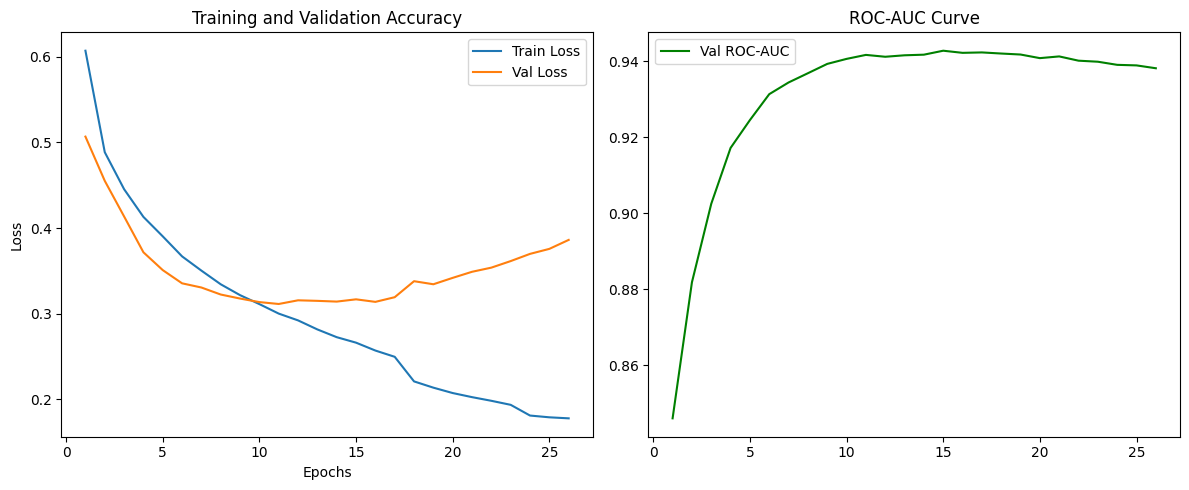

In [32]:
plot_learning_curves(lstm_history)

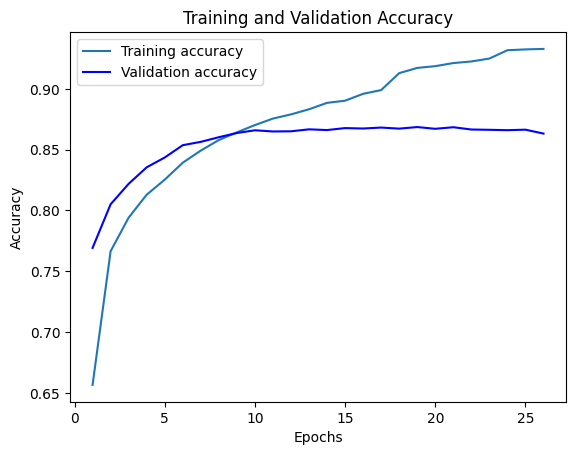

In [ ]:
plt.clf()   # 그림을 초기화합니다

lstm_epochs = range(1, len(lstm_history['train_loss']) + 1)

plt.plot(lstm_epochs , lstm_history["train_acc"], label='Training accuracy')
plt.plot(lstm_epochs , lstm_history["val_acc"],   label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

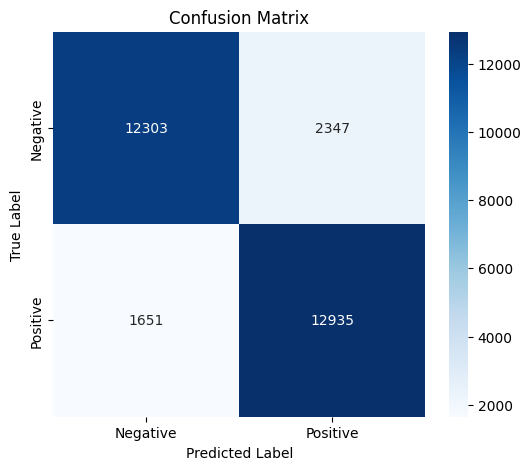

In [34]:
last_cm = lstm_history['val_cm'][-1]
plot_confusion_matrix(last_cm)

---
1D-CNN 모델 학습

In [35]:
cnn_model =  CnnModel(vocab_size, word_vector_dim).to(device)
print(cnn_model)

CnnModel(
  (embedding): Embedding(10000, 256)
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv1d(256, 32, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(256, 32, kernel_size=(4,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(256, 32, kernel_size=(5,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [36]:
cnn_history = train(train_loader, val_loader, cnn_model, device, loss_fn, epochs = epochs)

/home/user/anaconda3/envs/wsl_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - Train Loss: 0.5839, Train Accuracy: 0.6772 - Validation Loss: 0.4629, Validation Accuracy: 0.7760
Epoch 2/50 - Train Loss: 0.4890, Train Accuracy: 0.7604 - Validation Loss: 0.4231, Validation Accuracy: 0.7985
Epoch 3/50 - Train Loss: 0.4607, Train Accuracy: 0.7819 - Validation Loss: 0.4031, Validation Accuracy: 0.8117
Epoch 4/50 - Train Loss: 0.4381, Train Accuracy: 0.7975 - Validation Loss: 0.3844, Validation Accuracy: 0.8257
Epoch 5/50 - Train Loss: 0.4203, Train Accuracy: 0.8112 - Validation Loss: 0.3732, Validation Accuracy: 0.8307
Epoch 6/50 - Train Loss: 0.4019, Train Accuracy: 0.8230 - Validation Loss: 0.3574, Validation Accuracy: 0.8389
Epoch 7/50 - Train Loss: 0.3876, Train Accuracy: 0.8290 - Validation Loss: 0.3494, Validation Accuracy: 0.8449
Epoch 8/50 - Train Loss: 0.3757, Train Accuracy: 0.8382 - Validation Loss: 0.3433, Validation Accuracy: 0.8481
Epoch 9/50 - Train Loss: 0.3668, Train Accuracy: 0.8436 - Validation Loss: 0.3387, Validation Accuracy: 0.8496
E

In [37]:
test_loss, test_acc, *_  = validation(test_loader, cnn_model, loss_fn, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.3340, Test Accuracy: 0.8578


ROC-AUC:   0.9356
Precision: 0.8674
Recall:    0.8450


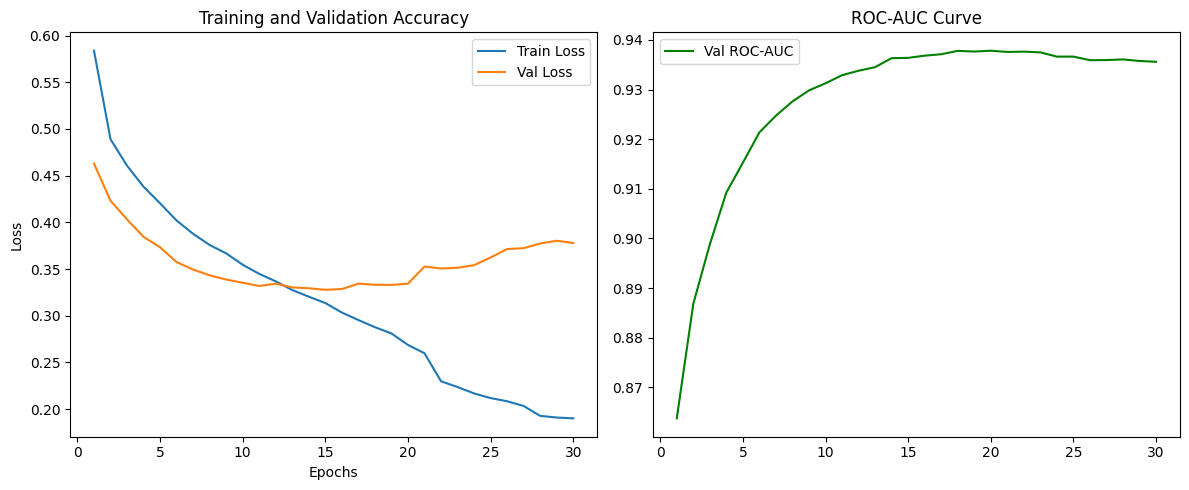

In [38]:
plot_learning_curves(cnn_history)

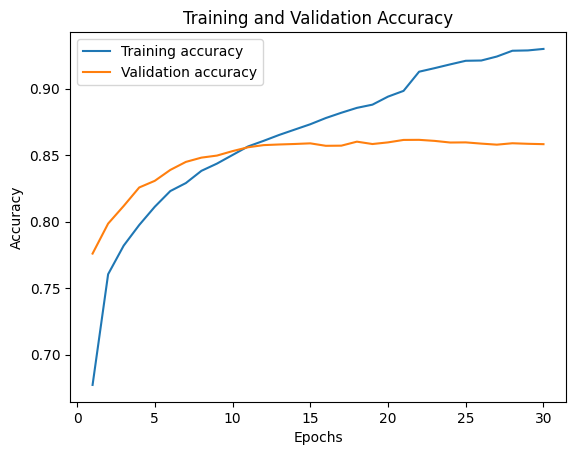

In [39]:
plt.clf()   # 그림을 초기화합니다

cnn_epochs = range(1, len(cnn_history['train_loss']) + 1)

plt.plot(cnn_epochs, cnn_history["train_acc"],  label='Training accuracy')
plt.plot(cnn_epochs, cnn_history["val_acc"],   label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

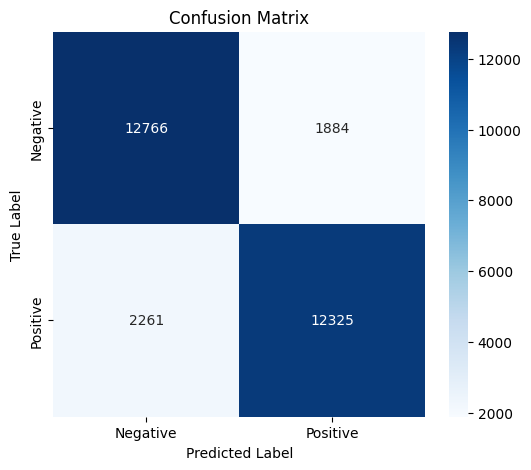

In [40]:
last_cm = cnn_history['val_cm'][-1]
plot_confusion_matrix(last_cm)

---
FFN 모델 학습

In [41]:
ffn_model = FFN(vocab_size, word_vector_dim).to(device)
print(ffn_model)

FFN(
  (embedding): Embedding(10000, 256)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


In [42]:
ffn_history = train(train_loader, val_loader, ffn_model, device, loss_fn, epochs = epochs)

/home/user/anaconda3/envs/wsl_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - Train Loss: 0.6564, Train Accuracy: 0.6013 - Validation Loss: 0.6100, Validation Accuracy: 0.7005
Epoch 2/50 - Train Loss: 0.5884, Train Accuracy: 0.6831 - Validation Loss: 0.5616, Validation Accuracy: 0.7366
Epoch 3/50 - Train Loss: 0.5531, Train Accuracy: 0.7146 - Validation Loss: 0.5304, Validation Accuracy: 0.7557
Epoch 4/50 - Train Loss: 0.5287, Train Accuracy: 0.7356 - Validation Loss: 0.5107, Validation Accuracy: 0.7665
Epoch 5/50 - Train Loss: 0.5107, Train Accuracy: 0.7475 - Validation Loss: 0.4943, Validation Accuracy: 0.7741
Epoch 6/50 - Train Loss: 0.4980, Train Accuracy: 0.7569 - Validation Loss: 0.4860, Validation Accuracy: 0.7821
Epoch 7/50 - Train Loss: 0.4872, Train Accuracy: 0.7648 - Validation Loss: 0.4791, Validation Accuracy: 0.7856
Epoch 8/50 - Train Loss: 0.4779, Train Accuracy: 0.7721 - Validation Loss: 0.4800, Validation Accuracy: 0.7871
Epoch 9/50 - Train Loss: 0.4671, Train Accuracy: 0.7806 - Validation Loss: 0.4589, Validation Accuracy: 0.7943
E

In [43]:
test_loss, test_acc, *_  = validation(test_loader, ffn_model, loss_fn, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.3485, Test Accuracy: 0.8471


ROC-AUC:   0.9282
Precision: 0.8548
Recall:    0.8475


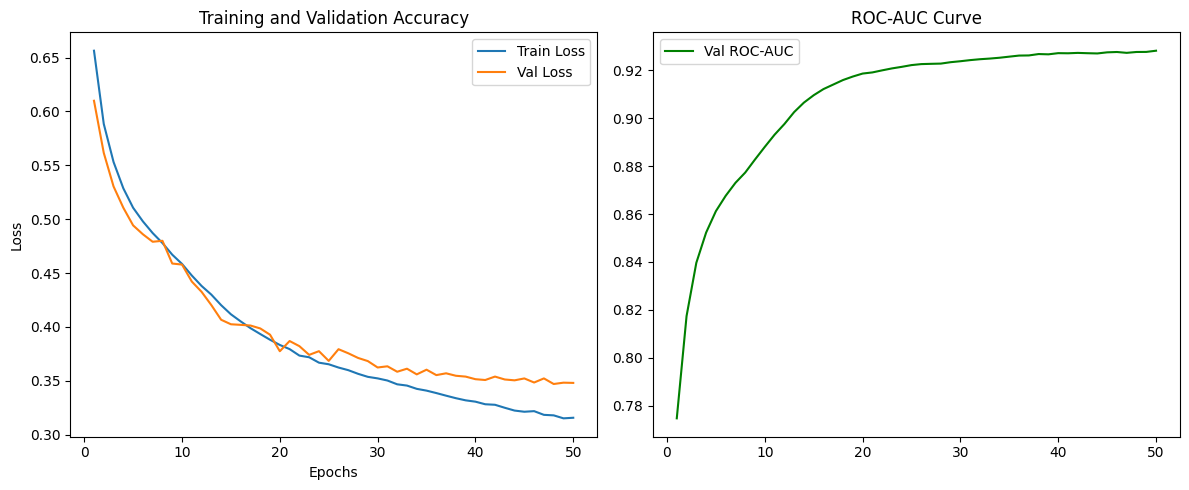

In [44]:
plot_learning_curves(ffn_history)

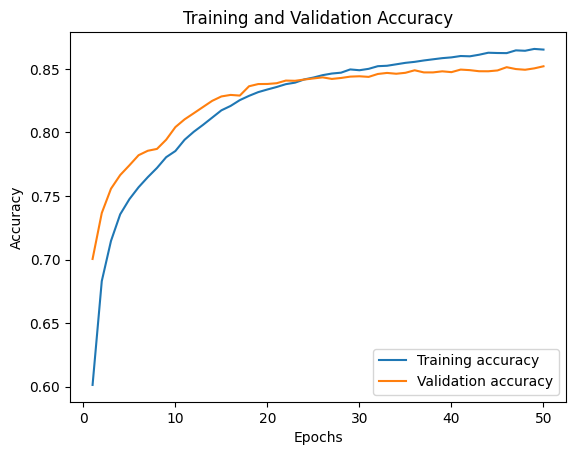

In [45]:
plt.clf()   # 그림을 초기화합니다
ffn_epochs = range(1, len(ffn_history['train_loss']) + 1)

plt.plot(ffn_epochs, ffn_history["train_acc"],  label='Training accuracy')
plt.plot(ffn_epochs, ffn_history["val_acc"],   label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

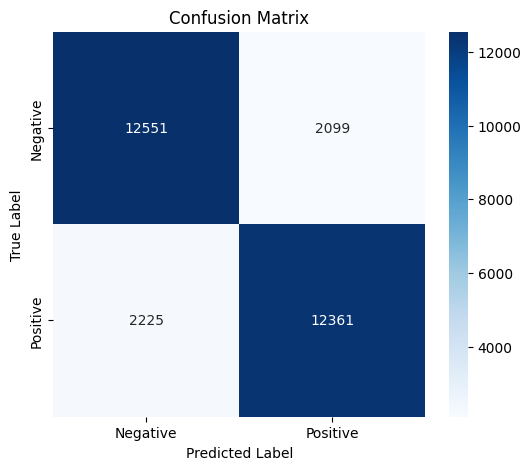

In [46]:
last_cm = ffn_history['val_cm'][-1]
plot_confusion_matrix(last_cm)

---
SentimentModel

In [47]:
Sent_model = SentimentModel(vocab_size, word_vector_dim).to(device)
print(Sent_model)

SentimentModel(
  (embedding): Embedding(10000, 256)
  (lstm): LSTM(256, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [48]:
Sent_history = train(train_loader, val_loader, Sent_model, device, loss_fn, epochs = epochs)

/home/user/anaconda3/envs/wsl_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - Train Loss: 0.6073, Train Accuracy: 0.6523 - Validation Loss: 0.4406, Validation Accuracy: 0.7904
Epoch 2/50 - Train Loss: 0.4834, Train Accuracy: 0.7737 - Validation Loss: 0.4012, Validation Accuracy: 0.8145
Epoch 3/50 - Train Loss: 0.4450, Train Accuracy: 0.7952 - Validation Loss: 0.3764, Validation Accuracy: 0.8297
Epoch 4/50 - Train Loss: 0.4197, Train Accuracy: 0.8115 - Validation Loss: 0.3654, Validation Accuracy: 0.8398
Epoch 5/50 - Train Loss: 0.3961, Train Accuracy: 0.8249 - Validation Loss: 0.3460, Validation Accuracy: 0.8488
Epoch 6/50 - Train Loss: 0.3734, Train Accuracy: 0.8399 - Validation Loss: 0.3417, Validation Accuracy: 0.8505
Epoch 7/50 - Train Loss: 0.3582, Train Accuracy: 0.8478 - Validation Loss: 0.3262, Validation Accuracy: 0.8587
Epoch 8/50 - Train Loss: 0.3446, Train Accuracy: 0.8539 - Validation Loss: 0.3246, Validation Accuracy: 0.8607
Epoch 9/50 - Train Loss: 0.3357, Train Accuracy: 0.8600 - Validation Loss: 0.3167, Validation Accuracy: 0.8640
E

In [49]:
test_loss, test_acc, *_  = validation(test_loader, Sent_model, loss_fn, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.3116, Test Accuracy: 0.8647


ROC-AUC:   0.9340
Precision: 0.8666
Recall:    0.8588


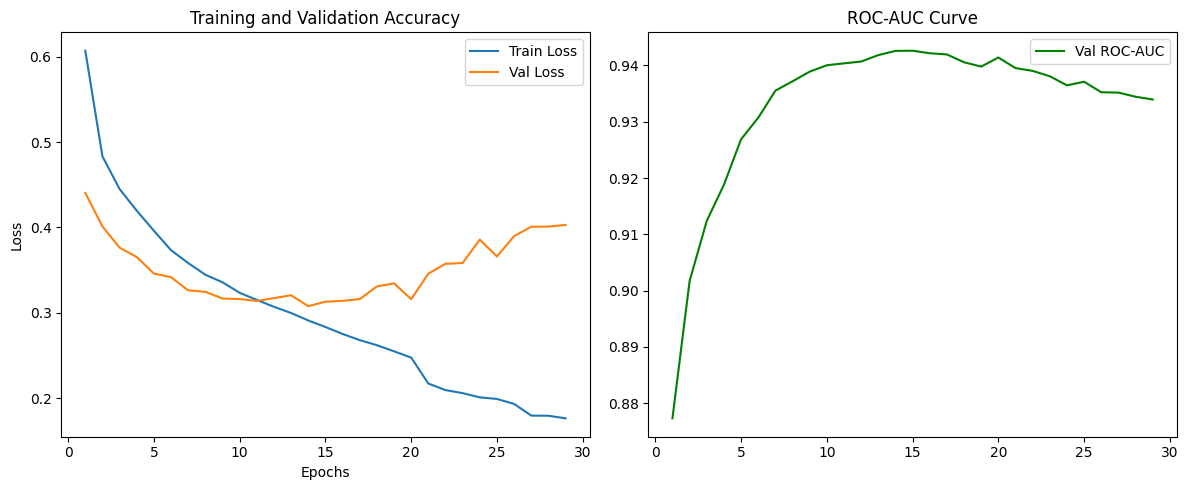

In [50]:
plot_learning_curves(Sent_history)

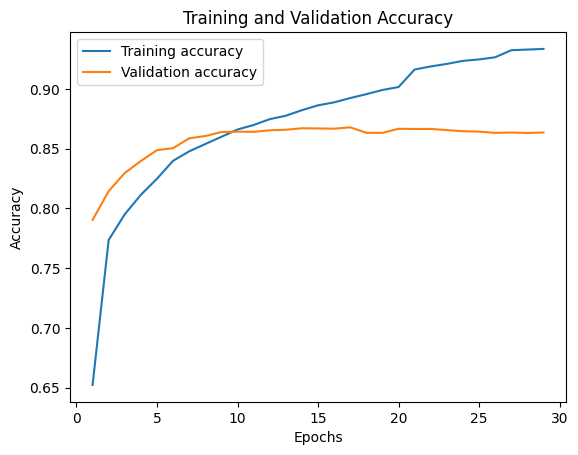

In [52]:
plt.clf()   # 그림을 초기화합니다
Sent_epochs = range(1, len(Sent_history['train_loss']) + 1)

plt.plot(Sent_epochs, Sent_history["train_acc"],  label='Training accuracy')
plt.plot(Sent_epochs, Sent_history["val_acc"],   label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

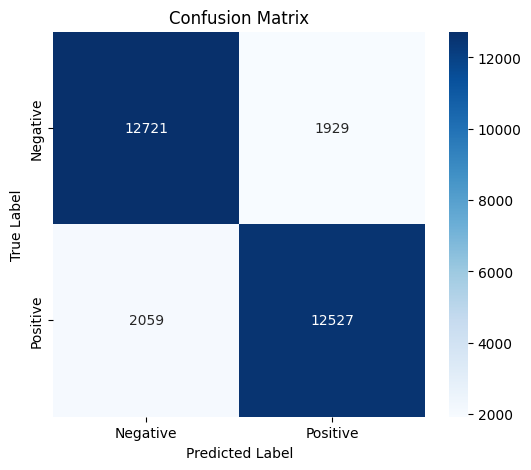

In [53]:
last_cm = Sent_history['val_cm'][-1]
plot_confusion_matrix(last_cm)

---
사전 임베딩 모델

In [54]:
embedding_layer = Sent_model.embedding
weights = embedding_layer.weight.detach().cpu().numpy()

print(weights.shape)  # shape: (vocab_size, embedding_dim)

(10000, 256)


In [55]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path ='./word2vec_emb/word2vec.txt'

with open(word2vec_file_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size - 4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
    vectors = Sent_model.embedding.weight.detach().cpu().numpy()
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, vectors[i, :]))))

In [56]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['나']
vector

array([ 0.01868385,  0.04365252, -0.01338572, -0.13366683,  0.05202731,
       -0.05295271,  0.1045917 , -0.11894674,  0.15064293,  0.04466001,
       -0.04852415,  0.04049064, -0.11568069, -0.18142432,  0.05486204,
        0.01655549, -0.01653821, -0.06651426, -0.03968061,  0.15185514,
        0.01387473, -0.04060952,  0.20230211,  0.04976216,  0.13988073,
        0.0331671 ,  0.03958683,  0.01960575,  0.0509573 , -0.03002978,
       -0.29171166,  0.31968123,  0.36322194,  0.11080364, -0.07190862,
        0.18540819, -0.1693604 , -0.1045256 , -0.09764321, -0.17941731,
       -0.02305774,  0.19794281, -0.13611527,  0.40491098, -0.22819674,
       -0.13860515,  0.1361674 , -0.05712845, -0.10081482,  0.19772601,
       -0.33156607, -0.12004397, -0.00076137, -0.27297047, -0.13043684,
        0.06885457,  0.0462576 , -0.3428535 ,  0.22464849,  0.2567476 ,
       -0.10364138,  0.24928533, -0.19284947,  0.20132183,  0.11133473,
        0.02743004, -0.24972232, -0.07540077, -0.0356239 , -0.08

In [57]:
word_vectors.similar_by_word("사랑")

[('아플', 0.4089786410331726),
 ('메가', 0.4026312828063965),
 ('사막', 0.40173935890197754),
 ('앙상블', 0.4003787338733673),
 ('카타르시스', 0.39865800738334656),
 ('예상외', 0.39810189604759216),
 ('호프만', 0.39567500352859497),
 ('주걸륜', 0.39497676491737366),
 ('옹', 0.3942263722419739),
 ('박신혜', 0.3925313949584961)]

In [58]:
from gensim.models import KeyedVectors

word2vec_path = data_dir + 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [59]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816874146461487),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.6003957390785217),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [60]:
embedding_matrix = torch.randn(vocab_size,300)
emb_model = SentimentModel_emb(vocab_size, 300, embedding_matrix, maxlen).to(device)
print(emb_model)

SentimentModel_emb(
  (embedding): Embedding(10000, 300)
  (conv1): Conv1d(300, 16, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


/tmp/ipykernel_64361/2134851887.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


In [61]:
embedding_history = train(train_loader, val_loader, emb_model, device, loss_fn, epochs = epochs)

/home/user/anaconda3/envs/wsl_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - Train Loss: 0.6548, Train Accuracy: 0.5890 - Validation Loss: 0.5510, Validation Accuracy: 0.7291
Epoch 2/50 - Train Loss: 0.5723, Train Accuracy: 0.6909 - Validation Loss: 0.4971, Validation Accuracy: 0.7590
Epoch 3/50 - Train Loss: 0.5366, Train Accuracy: 0.7151 - Validation Loss: 0.4701, Validation Accuracy: 0.7751
Epoch 4/50 - Train Loss: 0.5139, Train Accuracy: 0.7310 - Validation Loss: 0.4459, Validation Accuracy: 0.7898
Epoch 5/50 - Train Loss: 0.4883, Train Accuracy: 0.7573 - Validation Loss: 0.4305, Validation Accuracy: 0.8008
Epoch 6/50 - Train Loss: 0.4724, Train Accuracy: 0.7730 - Validation Loss: 0.4182, Validation Accuracy: 0.8031
Epoch 7/50 - Train Loss: 0.4608, Train Accuracy: 0.7811 - Validation Loss: 0.4084, Validation Accuracy: 0.8091
Epoch 8/50 - Train Loss: 0.4487, Train Accuracy: 0.7891 - Validation Loss: 0.3998, Validation Accuracy: 0.8120
Epoch 9/50 - Train Loss: 0.4320, Train Accuracy: 0.7953 - Validation Loss: 0.3953, Validation Accuracy: 0.8158
E

In [62]:
test_loss, test_acc, *_  = validation(test_loader, emb_model, loss_fn, device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.3924, Test Accuracy: 0.8140


ROC-AUC:   0.9021
Precision: 0.8244
Recall:    0.7999


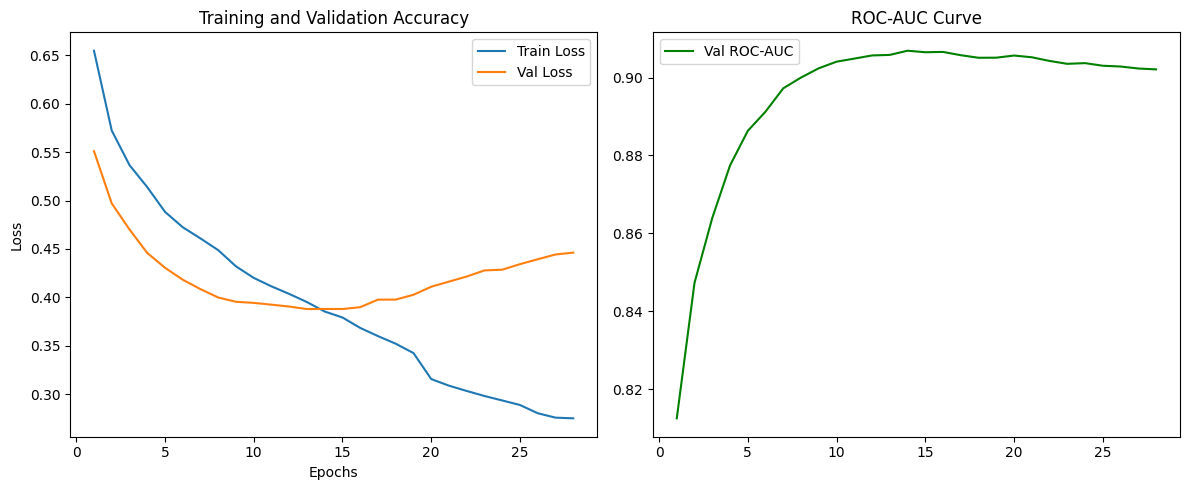

In [63]:
plot_learning_curves(embedding_history)

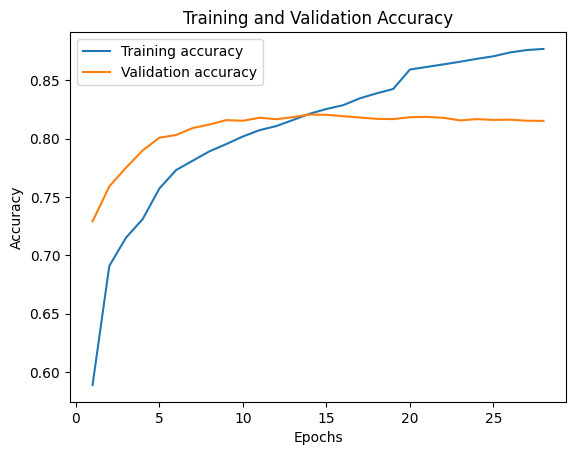

In [64]:
plt.clf()  
emb_epochs = range(1, len(embedding_history['train_loss']) + 1)
plt.plot(emb_epochs, embedding_history["train_acc"],  label='Training accuracy')
plt.plot(emb_epochs, embedding_history["val_acc"],   label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

---
전체 모델 비교

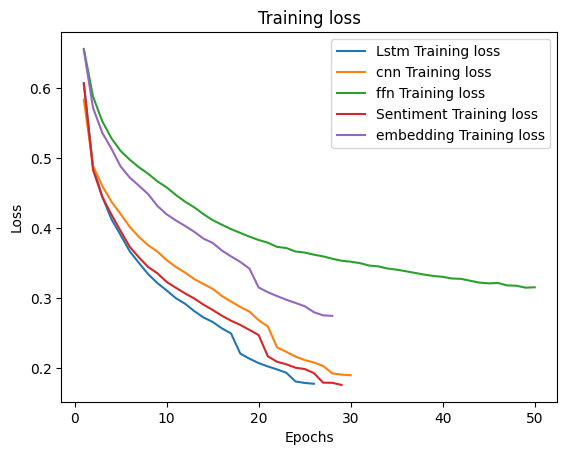

In [66]:
plt.plot(lstm_epochs, lstm_history['train_loss'], '-', label='Lstm Training loss')
plt.plot(cnn_epochs, cnn_history['train_loss'], '-', label='cnn Training loss')
plt.plot(ffn_epochs, ffn_history['train_loss'], '-', label='ffn Training loss')
plt.plot(Sent_epochs, Sent_history['train_loss'], '-', label='Sentiment Training loss')
plt.plot(emb_epochs, embedding_history['train_loss'], '-', label='embedding Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

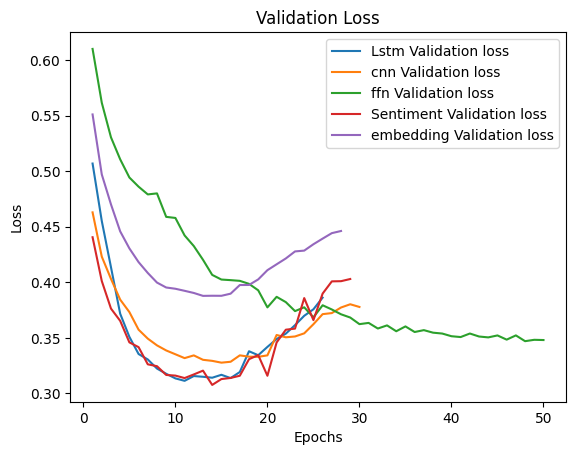

In [67]:
plt.plot(lstm_epochs,lstm_history['val_loss'], '-', label='Lstm Validation loss')
plt.plot(cnn_epochs, cnn_history['val_loss'], '-', label='cnn Validation loss')
plt.plot(ffn_epochs, ffn_history['val_loss'], '-', label='ffn Validation loss')
plt.plot(Sent_epochs, Sent_history['val_loss'], '-', label='Sentiment Validation loss')
plt.plot(emb_epochs, embedding_history['val_loss'], '-', label='embedding Validation loss')

plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

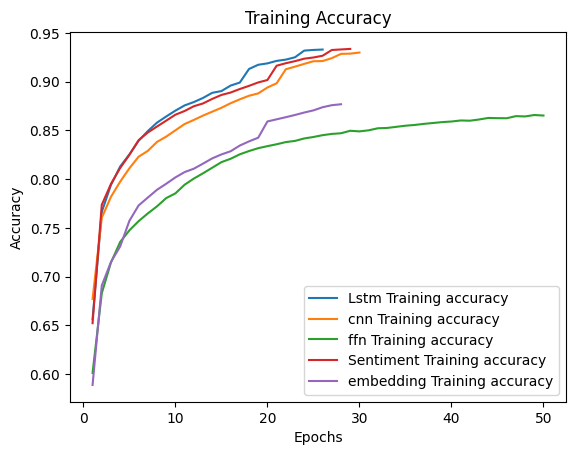

In [68]:
plt.clf()  

plt.plot(lstm_epochs, lstm_history['train_acc'], '-', label='Lstm Training accuracy')
plt.plot(cnn_epochs, cnn_history["train_acc"], '-', label='cnn Training accuracy')
plt.plot(ffn_epochs, ffn_history["train_acc"], '-', label='ffn Training accuracy')
plt.plot(Sent_epochs, Sent_history['train_acc'], '-', label='Sentiment Training accuracy')
plt.plot(emb_epochs, embedding_history['train_acc'], '-', label='embedding Training accuracy')

plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

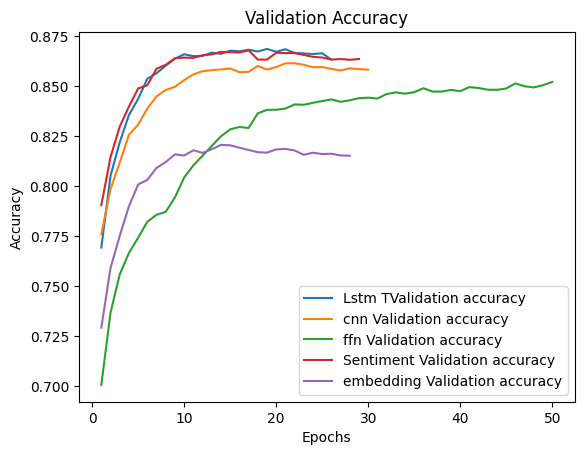

In [69]:
plt.clf()  

plt.plot(lstm_epochs, lstm_history['val_acc'], '-', label='Lstm TValidation accuracy')
plt.plot(cnn_epochs, cnn_history["val_acc"], '-', label='cnn Validation accuracy')
plt.plot(ffn_epochs, ffn_history["val_acc"], '-', label='ffn Validation accuracy')
plt.plot(Sent_epochs, Sent_history['val_acc'], '-', label='Sentiment Validation accuracy')
plt.plot(emb_epochs, embedding_history['val_acc'], '-', label='embedding Validation accuracy')

plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 모든 모델 비교 
- 동일한 하이퍼 파라미터, 동일한 데이터셋 사용, 구조만 다르게 구성  
- Training loss: 모든 모델이 생각보다 0으로 수렴하지 않음  
      원인: optimizer, 학습률, 분류기, data, vocab(quality, size)

- Validation loss: ffn 모델 제외 과대적합으로 의심되는 양상을 보임
    원인: 데이터 대비 모델 구조 적절성 부족 optimizer, 학습률, data, vocab(quality, size)

- Training accuracy: 적은 epoch으로 높은 정확도를 보이나, val_data,test data에서 그렇지 않은 것을 확인할 수 있다
    원인: 과대적합 의심

Validation accuracy: 전반적으로 Training accuracy에 미치지 못하는 것을 알 수 있다.
    원인: 인코딩(MeCab, FastText) 개선 필요

- 모든 모델의 성능이 0.9를 넘기지 못한 것이 아쉽다.

---
optimizer 비교 (SentimentMode)

In [70]:
Sent_model_v2 = SentimentModel(vocab_size, word_vector_dim).to(device)
optimizer = optim.AdamW(Sent_model_v2.parameters(), lr=3e-4, weight_decay=1e-4)

In [71]:
Sent_history_v2 = train(train_loader, val_loader, Sent_model_v2, device, loss_fn, optimizer= optimizer, epochs = epochs)

/home/user/anaconda3/envs/wsl_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - Train Loss: 0.6517, Train Accuracy: 0.5934 - Validation Loss: 0.4882, Validation Accuracy: 0.7738
Epoch 2/50 - Train Loss: 0.5178, Train Accuracy: 0.7528 - Validation Loss: 0.4182, Validation Accuracy: 0.8088
Epoch 3/50 - Train Loss: 0.4707, Train Accuracy: 0.7825 - Validation Loss: 0.3929, Validation Accuracy: 0.8230
Epoch 4/50 - Train Loss: 0.4429, Train Accuracy: 0.7986 - Validation Loss: 0.3727, Validation Accuracy: 0.8343
Epoch 5/50 - Train Loss: 0.4238, Train Accuracy: 0.8098 - Validation Loss: 0.3669, Validation Accuracy: 0.8396
Epoch 6/50 - Train Loss: 0.4096, Train Accuracy: 0.8188 - Validation Loss: 0.3636, Validation Accuracy: 0.8449
Epoch 7/50 - Train Loss: 0.3964, Train Accuracy: 0.8263 - Validation Loss: 0.3557, Validation Accuracy: 0.8469
Epoch 8/50 - Train Loss: 0.3877, Train Accuracy: 0.8303 - Validation Loss: 0.3528, Validation Accuracy: 0.8503
Epoch 9/50 - Train Loss: 0.3793, Train Accuracy: 0.8358 - Validation Loss: 0.3510, Validation Accuracy: 0.8529
E

In [72]:
test_loss, test_acc, *_  = validation(test_loader, Sent_model_v2, loss_fn, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.3308, Test Accuracy: 0.8615


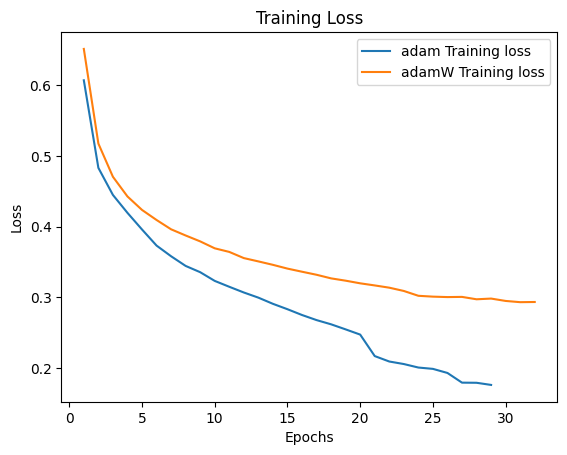

In [73]:
Sent_v2_epochs = range(1, len(Sent_history_v2['train_loss']) + 1)

plt.plot(Sent_epochs, Sent_history['train_loss'], label='adam Training loss')
plt.plot(Sent_v2_epochs , Sent_history_v2['train_loss'], label='adamW Training loss')

plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

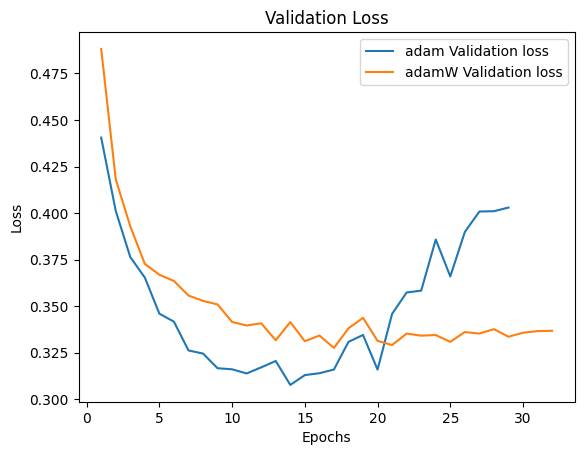

In [74]:
plt.plot(Sent_epochs , Sent_history['val_loss'], label='adam Validation loss')
plt.plot(Sent_v2_epochs , Sent_history_v2['val_loss'], label='adamW Validation loss')

plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

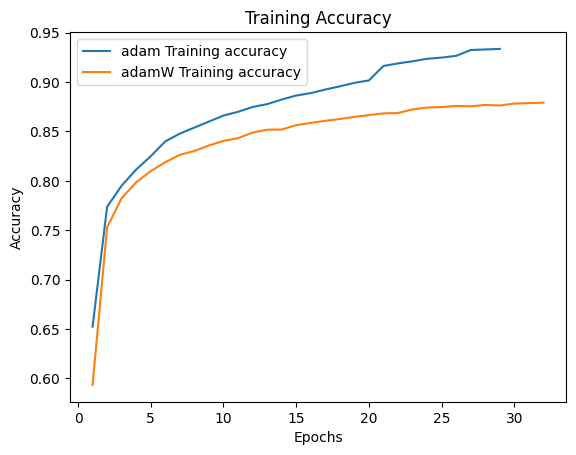

In [75]:
plt.clf()   # 그림을 초기화합니다

plt.plot(Sent_epochs, Sent_history["train_acc"],  label='adam Training accuracy')
plt.plot(Sent_v2_epochs , Sent_history_v2["train_acc"], label='adamW Training accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

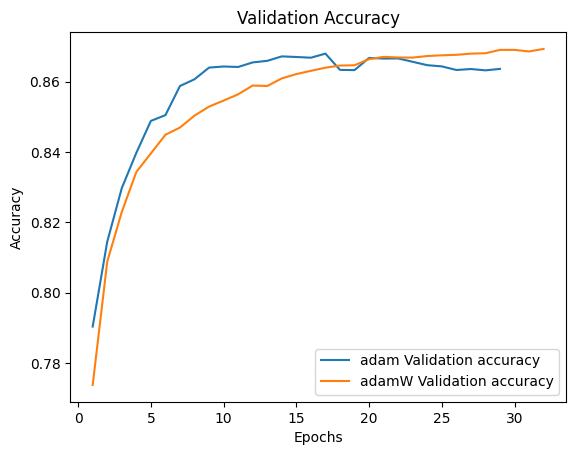

In [76]:
plt.clf()   # 그림을 초기화합니다

plt.plot(Sent_epochs, Sent_history["val_acc"], label='adam Validation accuracy')
plt.plot(Sent_v2_epochs , Sent_history_v2["val_acc"],  label='adamW Validation accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

---
optimizer 비교 (1D CNN)

In [77]:
cnn_model_v2 =  CnnModel(vocab_size, word_vector_dim).to(device)
optimizer = torch.optim.AdamW(cnn_model_v2.parameters(), lr=3e-4, weight_decay=1e-4)

In [78]:
cnn_history_v2  = train(train_loader, val_loader, cnn_model_v2 , device, loss_fn, optimizer = optimizer, epochs = epochs)

/home/user/anaconda3/envs/wsl_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - Train Loss: 0.5955, Train Accuracy: 0.6684 - Validation Loss: 0.4709, Validation Accuracy: 0.7767
Epoch 2/50 - Train Loss: 0.4898, Train Accuracy: 0.7634 - Validation Loss: 0.4238, Validation Accuracy: 0.7996
Epoch 3/50 - Train Loss: 0.4538, Train Accuracy: 0.7863 - Validation Loss: 0.4037, Validation Accuracy: 0.8108
Epoch 4/50 - Train Loss: 0.4318, Train Accuracy: 0.8008 - Validation Loss: 0.3811, Validation Accuracy: 0.8235
Epoch 5/50 - Train Loss: 0.4162, Train Accuracy: 0.8102 - Validation Loss: 0.3696, Validation Accuracy: 0.8323
Epoch 6/50 - Train Loss: 0.4021, Train Accuracy: 0.8194 - Validation Loss: 0.3622, Validation Accuracy: 0.8356
Epoch 7/50 - Train Loss: 0.3925, Train Accuracy: 0.8270 - Validation Loss: 0.3583, Validation Accuracy: 0.8387
Epoch 8/50 - Train Loss: 0.3817, Train Accuracy: 0.8308 - Validation Loss: 0.3547, Validation Accuracy: 0.8424
Epoch 9/50 - Train Loss: 0.3757, Train Accuracy: 0.8356 - Validation Loss: 0.3524, Validation Accuracy: 0.8440
E

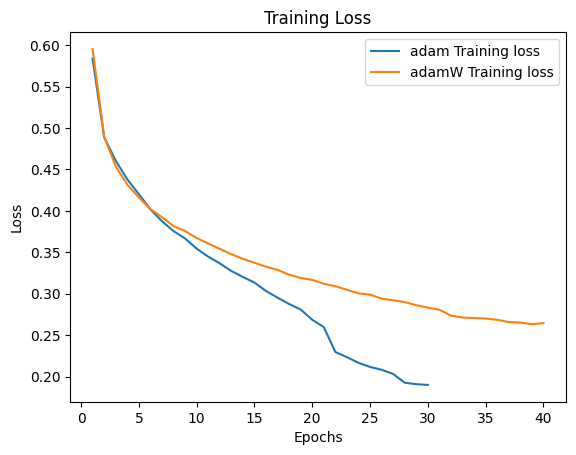

In [79]:
cnn_v2_epochs = range(1, len(cnn_history_v2['train_loss']) + 1)

plt.plot(cnn_epochs, cnn_history['train_loss'], label='adam Training loss')
plt.plot(cnn_v2_epochs, cnn_history_v2['train_loss'], label='adamW Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

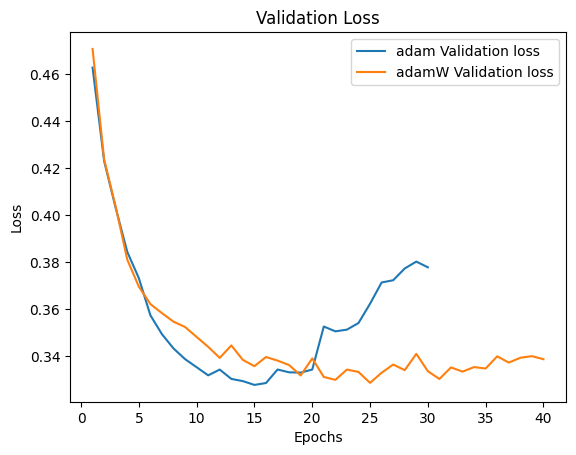

In [80]:
plt.plot(cnn_epochs,  cnn_history['val_loss'], label='adam Validation loss')
plt.plot(cnn_v2_epochs , cnn_history_v2['val_loss'], label='adamW Validation loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

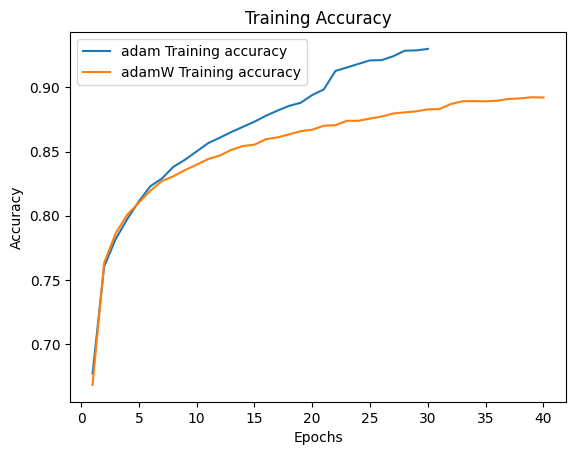

In [81]:
plt.clf()   # 그림을 초기화합니다

plt.plot(cnn_epochs, cnn_history["train_acc"], label='adam Training accuracy')
plt.plot(cnn_v2_epochs, cnn_history_v2["train_acc"],  label='adamW Training accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

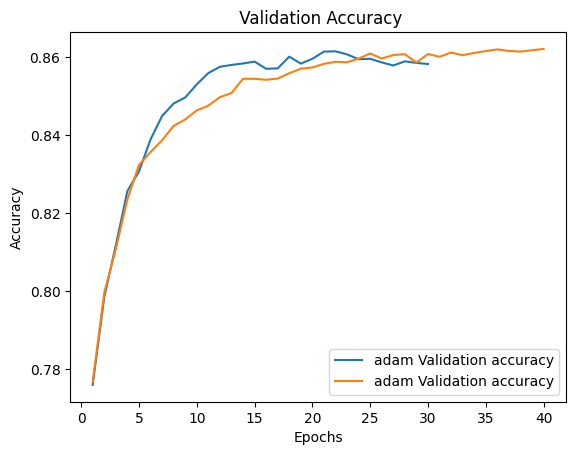

In [82]:
plt.clf()   # 그림을 초기화합니다

plt.plot(cnn_epochs, cnn_history["val_acc"], label='adam Validation accuracy')
plt.plot(cnn_v2_epochs, cnn_history_v2["val_acc"], label='adam Validation accuracy')
plt.title(' Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Adam vs AdamW 비교 (SentimentMode, 1D CNN)
AdamW와 Adam에 동일한 학습률, weight_decay를 사용  
Training loss: AdamW의 그래프가 일정구간에서 Training loss가 줄어들지 않는 것을 확인할 수 있음  
Validation loss: AdamW의 그래프가 안정적으로 수렴하는 것을 확인할 수 있음 (Adam과 달리 발산하지 않음)  
Training accuracy: AdamW의 그래프가 낮은 것을 확인할 수 있다.   
Validation accuracy: AdamW의 그래프가 높은 것을 확인할 수 있다.  


- 현재 실험 환경에서 AdamW가 Adam보다 일반화 성능을 높게 모델을 최적화하는 것을 알 수 있다.

---
### 문제점 및 개선 방안:
- 과대적합(Overfitting) 방지 및 일반화 성능 강화:
    문제점:  
    Pretrain 시 학습률 0.001 설정에서 모델이 훈련 데이터에 과도하게 최적화되어 검증 성능이 떨어지는 과대적합 현상 발생.

    개선 방안:  
    Dropout 추가: 뉴런을 일정 확률로 비활성화하여 특정 노드에 대한 의존도를 낮춤.  
    정규화(Regularization) 적용: 가중치 크기에 패널티를 부여하여 모델의 복잡도를 억제.  

- 텍스트 전처리 및 Vocab 효율화:
    문제점:  
    MeCab 형태소 분석 시 마침표(.)와 같은 문장 기호가 어휘 사전(Vocab)에 포함되어 모델의 연산 효율 저해 및 노이즈로 작용.

    개선 방안: 불용어(Stopwords) 목록에 문장 기호를 추가하여 전처리 단계에서 제거함으로써 학습 데이터의 품질 개선.

- 최적화 알고리즘 변경 (Optimizer):
    문제점: 기존 Adam 방식은 가중치 감쇠(Weight Decay)가 제대로 작동하지 않아 일반화 성능에 한계가 있음.

    개선 방안: AdamW는 가중치 감쇠를 기울기 업데이트와 분리하여 처리함으로써, Adam보다 더 나은 일반화 성능을 얻을 수 있기 때문에 AdamW로 변경.


### 회고:
생각보다 한국어 데이터를 처리하는 것이 어렵다는 것을 다시금 깨달았다... 영화 리뷰의 긍정, 부정을 판단하는 단순한 모델임에도 모델의 성능을 충분히 끌어내지 못한 점이 아쉬웠다.